# Electron MVA Tutorial

Hello, good to see you again! This is the main part of the tutorial, where we inspect and understand the ntuples a bit, before finally training a few BTDs to separate real prompt electrons from fakes.

## Prerequesites

### Install Python packages

We need to install two additional Python packages to run this notebook:

* [uproot](https://github.com/scikit-hep/uproot) to open ROOT files
* [tqdm](https://github.com/tqdm/tqdm) to draw progessbars

The other packages we rely on, in particular [xgboost](https://xgboost.readthedocs.io/en/latest/) for training BDTs, [pandas](https://pandas.pydata.org/) and [sklearn](https://scikit-learn.org/stable/index.html) are already installed in the SWAN environment.

You can execute bash commands withing the notebook by putting an exclamation mark `!` in front of them. You can uncomment the following cell and run it to invoke `pip` to install the missing packages:

In [1]:
#!pip install --user uproot tqdm

After the installations are finished, you have to restart the notebook kernel with the little circular arrow button in the toolbar above. You may now comment out the pip command again so it's not always run when you execute all cells in this notebook.

### Login with you CERN account to get Ntuples from EOS

In the first part of this tutorial, we showed you how to create the Electron MVA ntuples and you produced them yourself for one ROOT file. One file is unfortunately not enough for training the MVA.

We processed the whole Run 3 __DY+Jets__ MC sample for you and put the ROOT files into the EOS user space. To access them, please login to EOS by running the cells below (don't forget to change the username to yours):

In [2]:
username = "rembserj"

In [3]:
import getpass
import os
if os.system('klist | grep Default | grep ' + username + '@CERN.CH'):
    os.system('echo %s' % getpass.getpass() + " | kinit " + username)

········


## Electron MVA Ntuple Data

Let's import __uproot__ to open ROOT files, __glob__ to  search for files, __pandas__ for DataFrames and __tqdm__ for progress bars.

In [4]:
import uproot
import glob
import pandas as pd
from tqdm import tqdm

We need a lot of events to train the Electron MVA well, but using the full dataset would take too long in this tutorial. Let's just get the names of __10 files___.

In [5]:
n_files = 10
root_files = glob.glob("/eos/user/r/rembserj/ntuples/electron_mva_run3/*.root")[:n_files]

You can open a file with `uproot.open` and get the ROOT file directory structure by callling `allkeys`.
Like in C++ ROOT, ignore the semicolon and the numbers after it in the names.

In [6]:
f = uproot.open(root_files[0])
f.allkeys()

['ntuplizer;1', 'ntuplizer/tree;1']

There we go, the TTree with the electron data we seek must be `ntuplizer/tree`!

With that knowledge we can write a function that takes the path to a Electron MVA Ntuple file and returns a DataFrame with all the data except for some columns we won't use.

In [7]:
unneccesary_columns = ['ele_index',
       'Spring16GPV1Vals', 'Spring16GPV1RawVals', 'Spring16HZZV1Vals',
       'Spring16HZZV1RawVals', 'Fall17NoIsoV2Vals',
       'Fall17IsoV2Vals', 'Fall17IsoV1Vals',
       'Fall17NoIsoV1Vals', 'Spring16GPV1wp80', 'Spring16GPV1wp90',
       'Spring16HZZV1wpLoose', 'Fall17noIsoV2wp80', 'Fall17noIsoV2wpLoose',
       'Fall17noIsoV2wp90', 'Fall17isoV2wpHZZ', 'Fall17isoV2wp80',
       'Fall17isoV2wpLoose', 'Fall17isoV2wp90', 'Fall17noIsoV1wp90',
       'Fall17noIsoV1wp80', 'Fall17noIsoV1wpLoose', 'Fall17isoV1wp90',
       'Fall17isoV1wp80', 'Fall17isoV1wpLoose', 'nEvent', 'nRun', 'nLumi']

def get_df(root_file_name):
    f = uproot.open(root_file_name)
    if len(f.allkeys()) == 0:
        return pd.DataFrame()
    df = uproot.open(root_file_name)["ntuplizer/tree"].pandas.df()
    return df.drop(unneccesary_columns, axis=1)

Let's use this function in a loop to load all files and combine the DataFrames with `pandas.concat`:

In [8]:
df = pd.concat((get_df(f) for f in  tqdm(root_files)), ignore_index=True)

100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


We can check what columns we have in this data (or "branches" if you come from ROOT):

In [9]:
df.columns

Index([u'genNpu', u'vtxN', u'ele_q', u'ele_3q', u'matchedToGenEle', u'rho',
       u'ele_pt', u'ele_oldsigmaietaieta', u'ele_oldsigmaiphiiphi',
       u'ele_oldcircularity', u'ele_oldr9', u'ele_scletawidth',
       u'ele_sclphiwidth', u'ele_hadronicOverEm', u'ele_oldhe', u'ele_kfhits',
       u'ele_kfchi2', u'ele_gsfchi2', u'ele_fbrem', u'ele_gsfhits',
       u'ele_expected_inner_hits', u'ele_conversionVertexFitProbability',
       u'ele_ep', u'ele_eelepout', u'ele_IoEmIop', u'ele_deltaetain',
       u'ele_deltaphiin', u'ele_deltaetaseed', u'ele_psEoverEraw',
       u'ele_pfPhotonIso', u'ele_pfChargedHadIso', u'ele_pfNeutralHadIso',
       u'scl_E', u'scl_Et', u'scl_eta', u'scl_phi', u'ele_sclRawE',
       u'ele_sclNclus', u'ele_olde15', u'ele_olde25max', u'ele_olde55',
       u'ele_ecalE', u'ele_ecalErr', u'ele_trackErr', u'ele_combErr',
       u'ele_PFcombErr', u'ele_pfSumPUIso', u'ele_SCfbrem', u'ele_eClass',
       u'ele_nbrem', u'ele_oldhebc', u'ele_hebc', u'ele_isEB', u'ele_isEE'

That's a lot of information! Let's not try to understand everything at one, but explain when needed.

## Categorizing Electrons as Signal or Background

To say it once more: signal will be reconstructed electrons that match to a true prompt electron, while the background will be all unmatched and non-prompt electrons. Electrons from tau decays should be ignored.

The electron ntuplizer stores the category to which the electron belongs in the `matchedToGenEle` branch, and you can check the [ntuplizer source code](https://github.com/cms-sw/cmssw/blob/master/RecoEgamma/ElectronIdentification/plugins/ElectronMVANtuplizer.cc#L139) to learn which number corresponds to which category (starting from `UNMATCHED = 0`).

The electrons from taus correspond to `matchedToGenEle = 2`, so let's drop them from the data frame. You can use the `query` methods of dataframes to select a subset of the dataframe based on a selection query:

In [10]:
df = df.query("matchedToGenEle != 2")

Also we don't care about the distinction between non-prompt and unmatched electrons, so let's set both categories to the value zeros.

In [11]:
df.loc[df["matchedToGenEle"] != 1, "matchedToGenEle"] = 0

Very good, now `matchedToGenEle = 1` corresponds to signal and `matchedToGenEle = 0` to background.

Finally, we drop the electrons that fall outside the detector acceptance beyond $|\eta|$ = 2.5 and throw out the electrons below 10 GeV as they are usually not used.

In [12]:
df = df.query("abs(scl_eta) < 2.5")
df = df.query("ele_pt >= 10")

Here is a little helper function to plot histograms with distributions for signal and background electrons.

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def get_label(name):
    if name == 0:
        return "background"
    else:
        return "signal"

def plot_electrons(df, column, bins, logscale=False, ax=None, title=None):
    if ax is None:
        ax = plt.gca()
    for name, group in df.groupby("matchedToGenEle"):
        group[column].hist(bins=bins, histtype="step", label=get_label(name), ax=ax, density=True)
    ax.set_ylabel("density")
    ax.set_xlabel(column)
    ax.legend()
    ax.set_title(title)
    if logscale:
        ax.set_yscale("log", nonposy='clip')

Let's take a look at the $p_T$ and $\eta$ distributions to see if they look as expected:

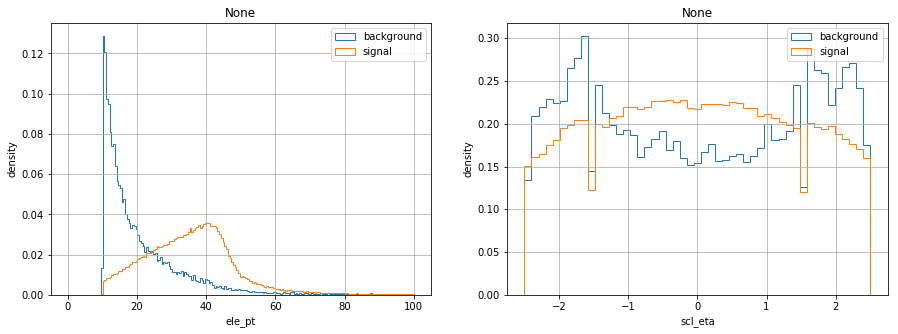

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_electrons(df, "ele_pt", np.linspace(0, 100, 200), ax=axes[0])
plot_electrons(df, "scl_eta", np.linspace(-2.5, 2.5, 50), ax=axes[1])
plt.show()

Seems reasonable! The true prompt electrons have the $p_T$ peak that you expect from Z boson decays, and the fakes have the expected exponential spectrum and are predominantly at high pseudorapidity.

It's also interesting to look at the distributions for the MVA input variables (also called "features"). The `ele_oldsigmaietaieta` for example represents the spread of the electromagnetic shower and is more peaked and has smaller values for true electrons.

Let's look at `ele_oldsigmaietaieta` separately for barrel and endcap:

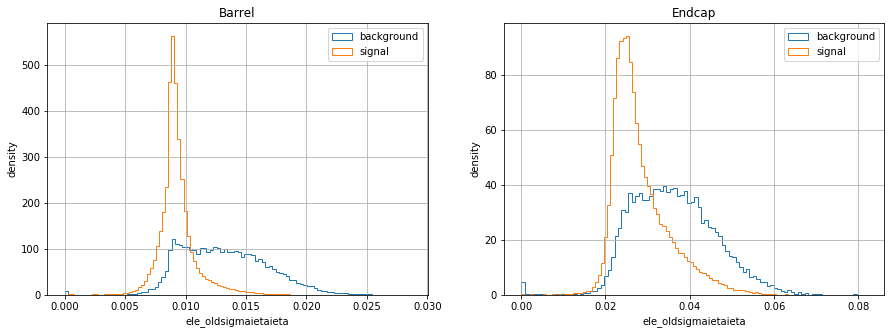

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_electrons(df.query("ele_isEB"), "ele_oldsigmaietaieta", 100, ax=axes[0], title="Barrel")
plot_electrons(df.query("ele_isEE"), "ele_oldsigmaietaieta", 100, ax=axes[1], title="Endcap")
plt.show()

Look at the X axis! The values are very different for barrel and endcap, which is the case also for other features. That's why we will have different trainings for barrel and endcap (also called EB and EE for Electronmagnetic Barrel/Endcap). In Run 2, we even split up the barrel in two different training regions (so 3 in total), because depending on the inner tracker the material budget is very different for the central Ecal barrel and the outer barrel. Naturally, the material budget influences the electron ID variables a lot.

At this point, feel free to look at other variables from the feature list below! Do you know what they represent? Unfortunately they are not explained in this tutorial, but there are many experts in CMS who are happy to explain them to you.

## Training the Boosted Decision Tree Classifiers

Let's write down a list with the the names of the features we will use. There are separate lists for EB and EE, because in the endcap we can use the fraction of the preshower energy as an additional feature. There is not preshower detector in the barrel.

In [16]:
features_barrel = ["ele_oldsigmaietaieta", "ele_oldsigmaiphiiphi",
            "ele_oldcircularity", "ele_oldr9", "ele_scletawidth",
            "ele_sclphiwidth", "ele_oldhe", "ele_kfhits", "ele_kfchi2",
            "ele_gsfchi2", "ele_fbrem", "ele_gsfhits",
            "ele_expected_inner_hits", "ele_conversionVertexFitProbability",
            "ele_ep", "ele_eelepout", "ele_IoEmIop", "ele_deltaetain",
            "ele_deltaphiin", "ele_deltaetaseed", "rho",
            "ele_pfPhotonIso", "ele_pfChargedHadIso", "ele_pfNeutralHadIso"]
            
features_endcap = features_barrel + ["ele_psEoverEraw"]

In [17]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [18]:
import xgboost2tmva

In [19]:
n_boost_rounds = 10
xgboost_params = {'eval_metric':'auc',
                  'max_depth' : 4,
                  'objective'  :'binary:logitraw'}

In [20]:
category_titles = ["EB1_5", "EB2_5", "EE_5", "EB1_10", "EB2_10", "EE_10"]

In [21]:
for i, group_df in df.groupby("EleMVACats"):
    
    if i < 3:
        continue

    category = category_titles[i]
    
    features = features_endcap if "EE" in category else features_barrel
    
    X = group_df[features]
    y = group_df["matchedToGenEle"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    idx_train = X_train.index
    idx_test = X_test.index

    dmatrix_train = xgb.DMatrix(X_train.copy(), label=np.copy(y_train))
    dmatrix_test  = xgb.DMatrix(X_test.copy(), label=np.copy(y_test ))

    n_pos = np.sum(y_train == 1)
    n_neg = np.sum(y_train == 0)

    print(category + ":")
    print("training on {0} signal and {1} background electrons".format(n_pos, n_neg))

    xgboost_params["scale_pos_weight"] = 1. * n_neg / n_pos
    model = xgb.train(xgboost_params, dmatrix_train, num_boost_round=n_boost_rounds,
                      evals= [(dmatrix_train, 'train'),
                               (dmatrix_test, 'test')],
                      early_stopping_rounds=10,
                      verbose_eval=False)
    
    best_iteration = model.best_iteration + 1
    if best_iteration < n_boost_rounds:
        print("early stopping after {0} boosting rounds".format(best_iteration))
    print("")
    
    xgboost2tmva.convert_model(model.get_dump(),
                               input_variables=[(f,'F') for f in features],
                               output_xml='electron_id_{0}.xml'.format(i))
    
    model.save_model("electron_id_{0}.bin".format(i))

    df.loc[idx_train, "score"] = model.predict(dmatrix_train)
    df.loc[idx_test, "score"] = model.predict(dmatrix_test)
    
    df.loc[idx_train, "test"] = False
    df.loc[idx_test, "test"] = True

EB1_10:
training on 46516 signal and 4775 background electrons

EB2_10:
training on 37071 signal and 4799 background electrons

EE_10:
training on 47303 signal and 8446 background electrons



In [22]:
from sklearn import metrics

def plot_roc_curve(df, score_column, tpr_threshold=0.7, ax=None, color=None, linestyle='-', label=None):
    if ax is None:
        ax = plt.gca()
    if label is None:
        label = score_column
    fpr, tpr, thresholds = metrics.roc_curve(df["matchedToGenEle"], df[score_column])
    mask = tpr > tpr_threshold
    fpr, tpr = fpr[mask], tpr[mask]
    ax.semilogy(tpr, fpr, label=label, color=color, linestyle=linestyle)

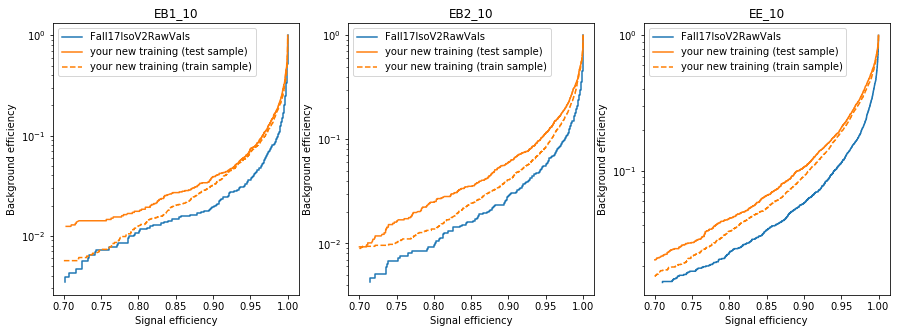

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, df_group in df.groupby("EleMVACats"):
    
    if i < 3:
        continue
    
    df_train = df_group.query("not test")
    df_test = df_group.query("test")
    
    
    ax = axes[i%3]
    plot_roc_curve(df_test, "Fall17IsoV2RawVals", ax=ax)
    plot_roc_curve(df_test, "score", ax=ax, label="your new training (test sample)")
    plot_roc_curve(df_train, "score", ax=ax, color="#ff7f02", linestyle='--', label="your new training (train sample)")
    ax.set_title(category_titles[i])
    ax.legend()
    ax.set_xlabel("Signal efficiency")
    ax.set_ylabel("Background efficiency")
    
plt.show()